# Covariance Propagation

In this notebook, we discuss how to use `dsgp4` to apply the first order approximation for propagating a covariance matrix:

\begin{equation}
P_{\pmb{x}_f}=\dfrac{\partial \pmb{x}}{\partial \textrm{TLE}_0}  P_{\textrm{TLE}_{0}}\dfrac{\partial \pmb{x}}{\partial \textrm{TLE}_0}^T\text{,}
\end{equation}
where $\textrm{TLE}_0$ is the initial TLE, at time $t_0$, and $\pmb{x}$ is the state vector in Cartesian TEME, at a certain propagation time $t_f$.

```{note}
An important aspect to notice is that the above formula, besides propagating the covariance, it also transforms the propagated covariance from TLE parameters, to Cartesian ones.
```

First, let's do the usual imports:


In [1]:
import dsgp4
import torch
import numpy as np

And let's also construct some TLE objects:

In [62]:
inp_file='''0 PSLV DEB *
1 35351U 01049QK  22066.70636923  .00002156  00000-0  63479-3 0  9999
2 35351  98.8179  29.5651 0005211  45.5944 314.5671 14.44732274457505
0 COSMOS 2251 DEB
1 34550U 93036UL  22068.48847750  .00005213  00000-0  16483-2 0  9994
2 34550  73.9920 106.8624 0177754 242.5189 115.7794 14.31752709674389
0 GGSE 3
1  1292U 65016C   22069.19982496  .00000050  00000-0  68899-4 0  9998
2  1292  70.0769  62.6868 0022019 223.3241 136.6137 14.00692829906555
0 CZ-2D DEB
1 35275U 08056E   22068.48794021  .00000595  00000-0  24349-3 0  9998
2 35275  98.8424  84.5826 0139050 155.2017 205.5930 14.25810852685662
0 FENGYUN 1C DEB
1 35237U 99025DQV 22069.17158141  .00009246  00000-0  14994-2 0  9992
2 35237  99.5946 147.0483 0055559  41.0775 319.4589 14.70446744775205
'''
tles=inp_file.splitlines()
#propagation times:
tsinces=torch.linspace(0,0.5*60*24,8)#0.5 days propagation
#we construct the TLE batch:
indexes=[]
for i in range(len(tsinces)):
    for k in range(0,len(tles),3):
        indexes.append(tles[k:3+k])
tles=[dsgp4.tle.TLE(index[:3]) for index in indexes]
#let's also repeat the times now:
tsinces=tsinces.repeat(5)

We initialize & propagate the TLEs and track the gradients:

In [63]:
#we initialize the TLEs w gradients:
tle_elements=dsgp4.initialize_tle(tles,with_grad=True)
#propagate the orbits:
state_teme=dsgp4.propagate_batch(tles,tsinces)

Let's construct the partials of the output w.r.t. the TLE parameters

In [64]:
#now we can build the partial derivatives matrix, of shape Nx6x9 (N is the number of tsince elements, 6 is the number of elements in the state vector, and 9 is the number of elements in the TLE):
dx_dtle = torch.zeros((len(tsinces),6,9))
for k in range(len(tsinces)):
    for i in range(6):
        tle_elements[k].grad=None
        state_teme[k].flatten()[i].backward(retain_graph=True)
        dx_dtle[k,i,:] = tle_elements[k].grad

Now, let's define some useful parameters:

In [66]:
Cov_xyz=np.zeros((len(tles),6,6))
Cov_rtn=np.zeros((len(tles),6,6))
#this is the initial TLE covariance matrix:
Cov_tle=np.array([[ 1.06817079e-23,  8.85804989e-25,  1.51328946e-24,
        -2.48167092e-13,  1.80784129e-11, -9.17516946e-17,
        -1.80719145e-11,  2.47782854e-14,  1.06374440e-19],
       [ 1.10888880e-26,  9.19571327e-28,  1.57097512e-27,
        -2.57618033e-16,  1.87675528e-14, -9.28440729e-20,
        -1.87608028e-14,  2.57219640e-17,  1.10539220e-22],
       [-3.62208982e-24, -3.00370060e-25, -5.13145502e-25,
         8.41515501e-14, -6.13025898e-12,  3.11161104e-17,
         6.12805538e-12, -8.40212641e-15, -3.61913778e-20],
       [-2.72347076e-13, -2.25849762e-14, -3.85837006e-14,
         6.69613552e-03, -4.60858400e-01,  2.44529381e-06,
         4.60848714e-01, -6.66633934e-04,  2.73554382e-10],
       [ 1.98398791e-11,  1.64526723e-12,  2.81073778e-12,
        -4.60858400e-01,  3.35783115e+01, -1.70385711e-04,
        -3.35662070e+01,  4.60149046e-02,  1.68286334e-07],
       [-1.00692291e-16, -8.34937429e-18, -1.42650203e-17,
         2.44529381e-06, -1.70385711e-04,  1.75093676e-05,
         1.70379140e-04, -2.42796071e-07, -2.62336921e-10],
       [-1.98327475e-11, -1.64467582e-12, -2.80972744e-12,
         4.60848714e-01, -3.35662070e+01,  1.70379140e-04,
         3.35541747e+01, -4.60131157e-02, -2.28248504e-07],
       [ 2.71925407e-14,  2.25500097e-15,  3.85239630e-15,
        -6.66633934e-04,  4.60149046e-02, -2.42796071e-07,
        -4.60131157e-02,  6.63783423e-05, -3.21657063e-12],
       [ 1.16764843e-19,  9.73507662e-21,  1.65971417e-20,
         2.73554368e-10,  1.68286335e-07, -2.62336921e-10,
        -2.28248505e-07, -3.21656925e-12,  2.21029182e-07]])/1000.
frob_norms=np.zeros((len(tles),))

def rotation_matrix(state):
    """
    Computes the UVW rotation matrix.

    Args:
        state (`numpy.array`): numpy array of 2 rows and 3 columns, where
                                    the first row represents position, and the second velocity.

    Returns:
        `numpy.array`: numpy array of the rotation matrix from the cartesian state.
    """
    r, v = state[0], state[1]
    u = r / np.linalg.norm(r)
    w = np.cross(r, v)
    w = w / np.linalg.norm(w)
    v = np.cross(w, u)
    return np.vstack((u, v, w))

def from_cartesian_to_rtn(state, cartesian_to_rtn_rotation_matrix=None):
    """
    Converts a cartesian state to the RTN frame.

    Args:
        state (`numpy.array`): numpy array of 2 rows and 3 columns, where
                                    the first row represents position, and the second velocity.
        cartesian_to_rtn_rotation_matrix (`numpy.array`): numpy array of the rotation matrix from the cartesian state. If None, it is computed.

    Returns:
        `numpy.array`: numpy array of the RTN state.
    """
    # Use the supplied rotation matrix if available, otherwise compute it
    if cartesian_to_rtn_rotation_matrix is None:
        cartesian_to_rtn_rotation_matrix = rotation_matrix(state)
    r, v = state[0], state[1]
    r_rtn = np.dot(cartesian_to_rtn_rotation_matrix, r)
    v_rtn = np.dot(cartesian_to_rtn_rotation_matrix, v)
    return np.stack([r_rtn, v_rtn]), cartesian_to_rtn_rotation_matrix


Finally, we can propagate all covariances...

In [67]:
for idx, tle in enumerate(tles):
    state_rtn, cartesian_to_rtn_rotation_matrix = from_cartesian_to_rtn(state_teme[idx].detach().numpy())
    #I construct the 6x6 rotation matrix from cartesian -> RTN
    transformation_matrix_cartesian_to_rtn = np.zeros((6,6))
    transformation_matrix_cartesian_to_rtn[0:3, 0:3] = cartesian_to_rtn_rotation_matrix
    transformation_matrix_cartesian_to_rtn[3:,3:] = cartesian_to_rtn_rotation_matrix

    Cov_xyz[idx,:,:]=np.matmul(np.matmul(dx_dtle[idx,:],Cov_tle),dx_dtle[idx,:].T)
    frob_norms[idx]=np.linalg.norm(Cov_xyz[idx,:,:],ord='fro')
    Cov_rtn[idx,:,:]=np.matmul(np.matmul(transformation_matrix_cartesian_to_rtn, Cov_xyz[idx,:,:]),transformation_matrix_cartesian_to_rtn.T)

Let's plot the Frobenius norm of each covariance for each TLE, as a function of time from TLE:

Text(0, 0.5, 'Frobenius norm of the covariance matrix')

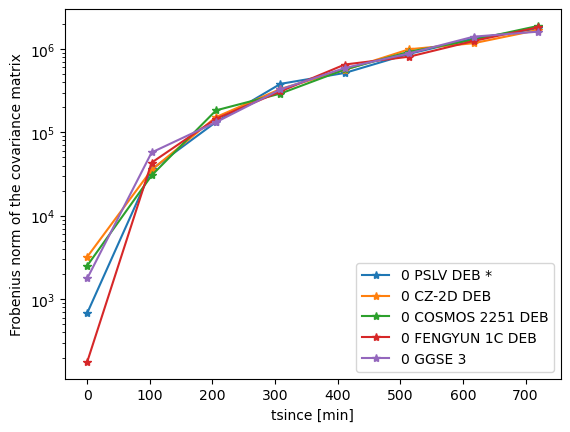

In [71]:
import matplotlib.pyplot as plt

indexes=[0,8,16,24,32,40]
for i in range(len(indexes)-1):
    plt.semilogy(tsinces[indexes[i]:indexes[i+1]].detach().numpy(),frob_norms[indexes[i]:indexes[i+1]],'-*',label=tles[indexes[i]].line0)
plt.legend()
plt.xlabel('tsince [min]')
plt.ylabel('Frobenius norm of the covariance matrix')